In [1]:
# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

In [2]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

### Pre-processing

In [814]:
data = pd.read_csv('../input/Sentiment.csv')

In [815]:
# Keeping only the neccessary columns
data = data[['sentiment','text']]

In [816]:
#data summary
data.describe()

,sentiment
count,8055.000000
mean,1.216760
std,0.735048
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [778]:
# dataframe information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8055 entries, 0 to 8054
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  8055 non-null   int64 
 1   text       8051 non-null   object
dtypes: int64(1), object(1)
memory usage: 126.0+ KB


In [779]:
# check for null values
data.isnull().sum()

sentiment    0
text         4
dtype: int64

In [780]:
#Remove NA Values
data = data.dropna(how='any',axis=0) 

In [781]:
# check for null values
data.isnull().sum()

sentiment    0
text         0
dtype: int64

In [817]:
#Cleansing data contain "@"
data['text']=data['text'].apply(lambda x: ' '.join([y for y in str(x).split() if '@' not in y]))

In [818]:
import string
#Check punctiation in
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [819]:
# Remove punctuations from dataset
def remove_punc(message):
  Test_punc_removed = [ char    for char in message if char not in string.punctuation   ]
  Test_punc_removed_join = ''.join(Test_punc_removed)
  return Test_punc_removed_join

In [820]:
# Join the characters again to form the string.
data.text = data.text.apply(lambda x: remove_punc(x))

In [821]:
# Stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Continental\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [822]:
# Stemming
#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer('Indonesian')

from snowballstemmer import stemmer
stemmer = stemmer('indonesian')

In [823]:
#Tokenizing and Stemming
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub('[^a-zA-Z]', ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words and len(token) >=3:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [824]:
# apply pre-processing to the text column
data['text'] = data.text.apply(lambda x: preprocess(x))

### Visualization 

In [782]:
#convert column
from sklearn.preprocessing import LabelEncoder

#Recoding job_type column label
labelencoder = LabelEncoder()
data['sentiment'] = labelencoder.fit_transform(data['sentiment'])

<Axes: xlabel='count', ylabel='sentiment'>

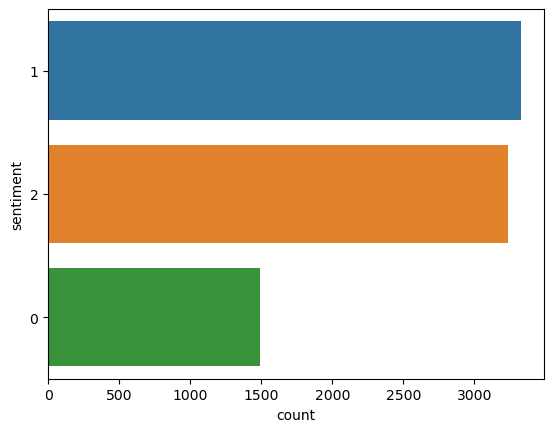

In [783]:
#Sentiment Plot
#sns.countplot(data['sentiment'])
sns.countplot(y = "sentiment", data=data, order=data['sentiment'].value_counts().iloc[:3].index)

In [784]:
data['sentiment'].nunique()

3

### Wordcloud

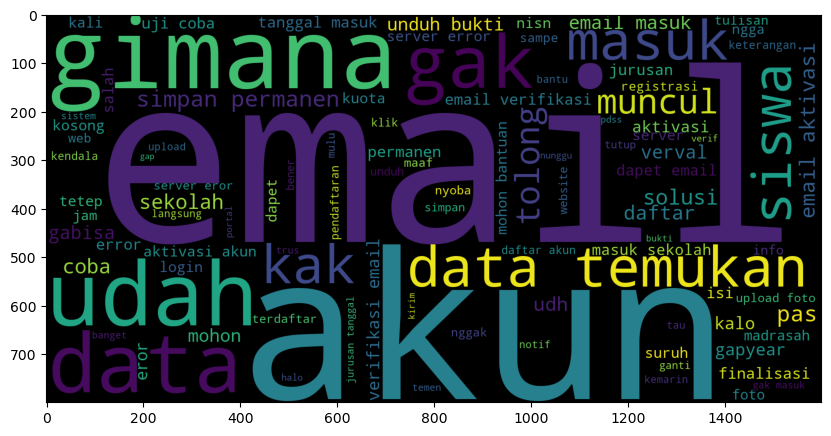

In [704]:
#Negative Sentiment
plt.figure(figsize = (10, 10))
wc = WordCloud(max_words = 100, width = 1600, height = 800, random_state = 1).generate( " ".join(data[ data['sentiment'] ==0]['text']))
plt.imshow(wc)

In [ ]:
#Positive Sentiment
plt.figure(figsize = (10, 10))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, random_state = 1).generate( " ".join(data[ data['sentiment'] ==1]['text']))
plt.imshow(wc)

In [ ]:
#Netral Sentiment
plt.figure(figsize = (10, 10))
wc = WordCloud(max_words = 1000, width = 1600, height = 800, random_state = 1).generate( " ".join(data[ data['sentiment'] ==2]['text']))
plt.imshow(wc)

### TOKENIZE AND PADDING

In [825]:
#Data Vectorization
#vectorize = [_text.split() for _text in data.text] 

data['vector'] = data.text.str.split()
data

,sentiment,text,vector
0,2,,[]
1,0,tolong websitenya klo down benerin mintt kmrn ...,"[tolong, websitenya, klo, down, benerin, mintt..."
2,0,kalo data ditemukan gimana,"[kalo, data, ditemukan, gimana]"
3,1,gini kmrn gabisa daftar teruss,"[gini, kmrn, gabisa, daftar, teruss]"
4,2,cbola,[cbola]
...,...,...,...
8050,0,min gangguan masuk kolom siswa ngisi nilai,"[min, gangguan, masuk, kolom, siswa, ngisi, ni..."
8051,2,terimaksih informasinya,"[terimaksih, informasinya]"
8052,2,info gap yer gimana nih min,"[info, gap, yer, gimana, nih, min]"
8053,2,maaf utk siswa jadwal mengklik permanen tangga...,"[maaf, utk, siswa, jadwal, mengklik, permanen,..."


In [826]:
# Obtain the total words present in the dataset
list_of_words = []
for i in data['vector']:
  for j in i:
    list_of_words.append(j)

In [ ]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))

In [828]:
# split the data into test and train 
x = data['vector']
y = data['sentiment']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [829]:
x_train.shape

(6444,)

In [830]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)

#Training Data
train_sequence = tokenizer.texts_to_sequences(x_train)

#Testing Data
test_sequence = tokenizer.texts_to_sequences(x_test)

In [831]:
train_sequence

[[],
 [],
 [3],
 [],
 [1043, 446, 39],
 [334, 1374, 382, 279, 2088],
 [736],
 [19, 2],
 [162, 194, 189, 190, 195],
 [162, 194, 189, 190, 195],
 [475, 475, 475, 2089, 1375, 2090],
 [],
 [1044, 413, 17],
 [],
 [1],
 [254],
 [5, 69, 1045, 517],
 [191],
 [184, 8, 6],
 [18, 184, 8, 14, 1046],
 [2091],
 [],
 [4, 11, 15, 26, 7],
 [1047, 134, 2092, 2093, 39, 5],
 [2094,
  2095,
  334,
  2096,
  647,
  2097,
  38,
  2098,
  2099,
  476,
  572,
  2100,
  1376,
  2101,
  1377,
  2102,
  414,
  648,
  647],
 [19, 11, 116],
 [1, 4, 3, 15, 7],
 [144, 3, 1378, 2103, 20, 95],
 [1, 33, 11, 138, 154],
 [6, 36, 856, 2],
 [857],
 [2,
  34,
  15,
  415,
  737,
  649,
  26,
  1379,
  126,
  136,
  255,
  2104,
  1379,
  126,
  2105,
  34],
 [1, 104, 5, 1048, 129, 219, 3, 15, 26, 7],
 [99, 8, 27, 1049, 289, 36, 22, 65, 100, 39, 204, 2106],
 [3, 2107, 3, 2108],
 [1],
 [196, 1380, 8],
 [1, 4, 176, 59],
 [2, 32, 177, 60, 210, 17],
 [1, 5, 4, 3, 75],
 [31, 22, 139, 29, 738, 76, 83],
 [146, 447, 17, 88],
 [33, 85

In [832]:
test_sequence

[[163, 36, 856, 29, 20],
 [1, 3],
 [5, 5, 4, 11, 26, 1761, 575],
 [71, 169, 102],
 [575, 5, 1],
 [1, 85, 15, 59],
 [630],
 [],
 [210, 216, 122, 18, 70, 1130, 135, 2],
 [191, 2],
 [104,
  4234,
  2393,
  97,
  97,
  50,
  258,
  16,
  5143,
  615,
  172,
  713,
  279,
  329,
  230,
  24,
  80],
 [4530],
 [14, 34, 2318, 29, 170, 728, 18, 381, 184, 15],
 [161, 120, 90],
 [1],
 [3, 209],
 [2, 10, 46, 3709],
 [1, 4, 3, 7],
 [1],
 [137, 312],
 [1, 33, 11, 5, 134, 1663, 7],
 [],
 [],
 [2, 239, 12, 565, 34, 287, 1188],
 [],
 [],
 [],
 [2, 25, 157],
 [1, 5],
 [1, 85, 1065, 799],
 [2019, 680, 672, 2019],
 [1631, 118, 35],
 [34, 278, 97, 937, 812, 109],
 [312, 17, 10, 46, 8],
 [241, 5, 3, 47],
 [296, 149, 13, 2],
 [91, 40, 99, 8, 466, 13],
 [1, 536, 7],
 [12, 910, 45],
 [57, 124, 216, 619, 1095, 1105, 18, 15, 606, 3182, 57],
 [103, 191, 485, 302],
 [1, 4, 3],
 [],
 [1],
 [432,
  166,
  1145,
  295,
  5062,
  501,
  170,
  148,
  57,
  29,
  164,
  618,
  170,
  250,
  248,
  53,
  172,
  314,
  9

In [840]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequence, maxlen=50)
padded_test = pad_sequences(test_sequence, maxlen=50)

In [841]:
# Convert the data to categorical 
y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)

In [842]:
print(y_train_cat.shape)
print(y_test_cat.shape)

(6444, 3)
(1611, 3)


### BUILD A CUSTOM-BASED DEEP NEURAL NETWORK

In [730]:
# Sequential Model
model = Sequential()
model.add(Embedding(total_words, output_dim=512))

model.add(LSTM(250))

model.add(Dense(128, activation='relu'))  #128 banyak neuron

model.add(Dropout(0.3)) #mengeluarkan 3%
model.add(Dense(3, activation = 'softmax')) #3 banyak kelasnya

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 512)         2835968   
                                                                 
 lstm_16 (LSTM)              (None, 250)               763000    
                                                                 
 dense_32 (Dense)            (None, 128)               32128     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 3)                 387       
                                                                 
Total params: 3,631,483
Trainable params: 3,631,483
Non-trainable params: 0
_________________________________________________________________


In [731]:
# train the model
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 10)

Epoch 1/10
161/161 [==============================] - 53s 307ms/step - loss: 0.6391 - acc: 0.7096 - val_loss: 0.4925 - val_acc: 0.8090
Epoch 2/10
161/161 [==============================] - 50s 314ms/step - loss: 0.3450 - acc: 0.8659 - val_loss: 0.4980 - val_acc: 0.8082
Epoch 3/10
161/161 [==============================] - 48s 298ms/step - loss: 0.2460 - acc: 0.9049 - val_loss: 0.5641 - val_acc: 0.8020
Epoch 4/10
161/161 [==============================] - 48s 296ms/step - loss: 0.2083 - acc: 0.9175 - val_loss: 0.6284 - val_acc: 0.7989
Epoch 5/10
161/161 [==============================] - 48s 296ms/step - loss: 0.1826 - acc: 0.9249 - val_loss: 0.6542 - val_acc: 0.8106
Epoch 6/10
161/161 [==============================] - 47s 295ms/step - loss: 0.1678 - acc: 0.9293 - val_loss: 0.7377 - val_acc: 0.7950
Epoch 7/10
161/161 [==============================] - 48s 298ms/step - loss: 0.1609 - acc: 0.9313 - val_loss: 0.7559 - val_acc: 0.8043
Epoch 8/10
161/161 [==============================] - 4

### ASSESS TRAINED MODEL PERFORMANCE

In [732]:
# predict test data
pred = model.predict(padded_test)

51/51 [==============================] - 9s 119ms/step


In [733]:
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [734]:
prediction

[2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 2,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 0,


In [735]:
# list containing original values
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [736]:
original

[0,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 0,
 2,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 0,
 1,
 1,
 2,
 2,
 0,
 0,
 1,
 1,
 2,
 0,


In [737]:
# acuracy score on text data
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, prediction)
accuracy

0.8150217256362507

In [739]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
cm

array([[243,   6,  56],
       [  7, 542, 127],
       [ 45,  57, 528]], dtype=int64)

<Axes: >

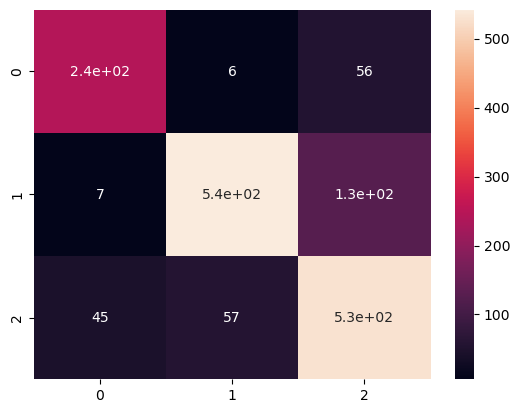

In [738]:
# Plot the confusion matrix
sns.heatmap(cm, annot = True)